In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

In [2]:
df = pd.read_csv('Student_Performance.csv')
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [3]:
df.info()          # Інформація про типи колонок
df.describe()      # Основні статистики чисельних колонок
df.isnull().sum()  # Перевірка пропущених значень

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

In [4]:
# --- Бінарні колонки ---
# Перевіримо, чи є така колонка
if 'Extracurricular Activities' in df.columns:
    df['Extracurricular Activities'] = df['Extracurricular Activities'].map({'No':0, 'Yes':1})

# --- Багатокласові / всі категоріальні ---
# Знаходимо всі об’єктні колонки (text/categorical)
cat_cols = df.select_dtypes(include='object').columns
print("Категоріальні колонки для кодування:", cat_cols)

# Перетворюємо їх у дамі-колонки
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

Категоріальні колонки для кодування: Index([], dtype='object')


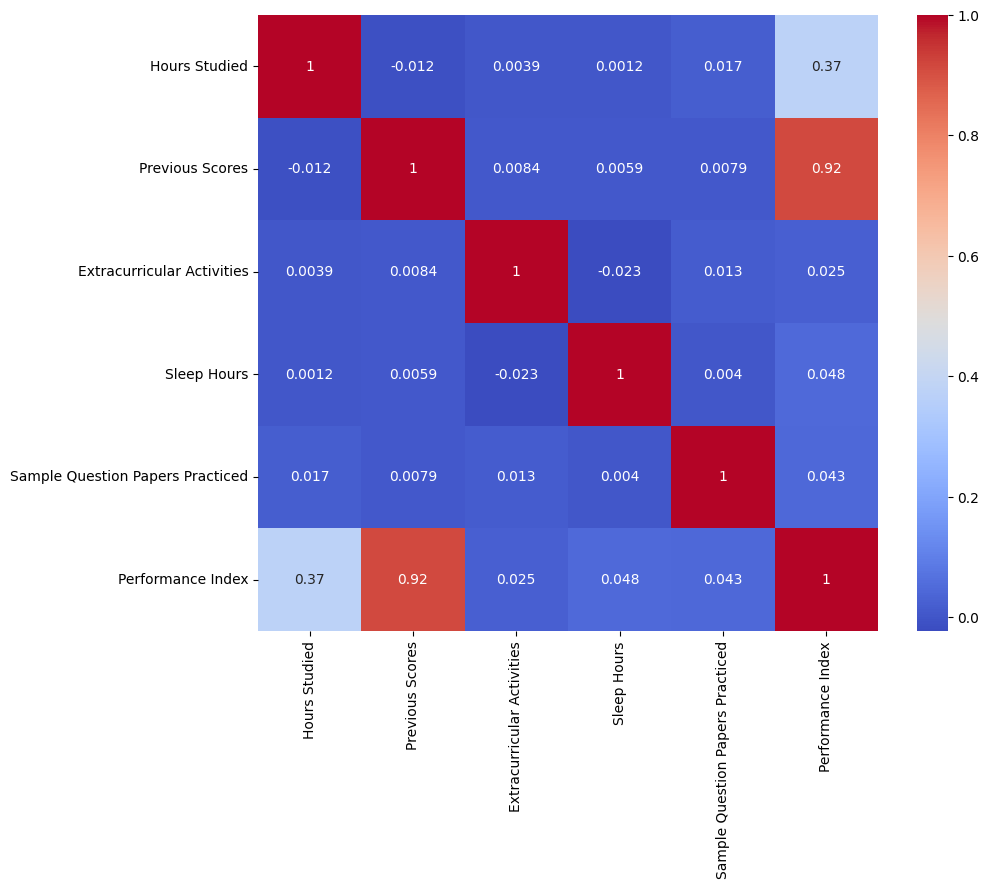

In [5]:
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.show()

In [6]:
X = df.drop(columns=['Performance Index'])
y = df['Performance Index']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Додаємо стовпчик одиниць для intercept
X_train_final = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_final = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

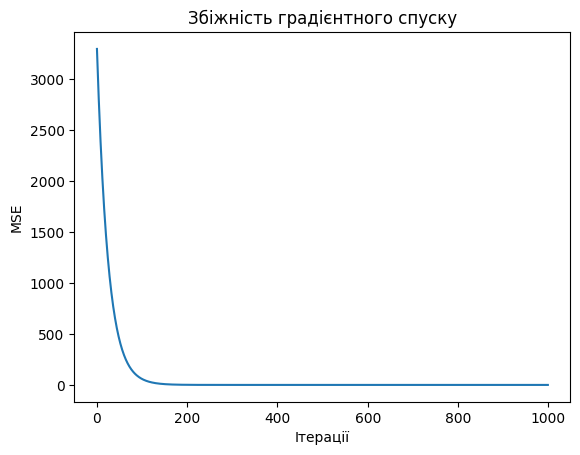

In [9]:
b = np.zeros(X_train_final.shape[1]) # ініціалізація параметрів - (m+1,) для інтерсепту + ознак
# гіперпараметри
learning_rate = 0.01 
epochs = 1000

# функція для обчислення MSE
def compute_cost(X, y, b):
    predictions = X.dot(b)
    errors = predictions - y
    mse = (1 / len(y)) * np.sum(errors ** 2)
    return mse

# функція градієнтного спуску
def gradient_descent(X, y, b, learning_rate, epochs):
    cost_history = []
    m = len(y)
    for _ in range(epochs):
        predictions = X.dot(b)
        errors = predictions - y
        gradient = (2/m) * X.T.dot(errors)
        b = b - learning_rate * gradient
        cost_history.append(compute_cost(X, y, b))
    return b, cost_history

# навчання моделі
b_final, cost_history = gradient_descent(X_train_final, y_train, b, learning_rate, epochs)

# візуалізація збіжності функції втрат
plt.plot(cost_history)
plt.xlabel('Ітерації')
plt.ylabel('MSE')
plt.title('Збіжність градієнтного спуску')
plt.show()

In [10]:
# оцінка моделі
# прогнозування
y_pred = X_test_final.dot(b_final)

# метрики
mse_test = np.mean((y_test - y_pred) ** 2)
r2 = 1 - np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2)
print("MSE:", mse_test)
print("R^2:", r2)

# порівняння з бейзлайном
baseline_pred = np.mean(y_train)
baseline_mse = np.mean((y_test - baseline_pred)**2)
print("Baseline MSE:", baseline_mse)


MSE: 4.082628391766479
R^2: 0.9889832909755435
Baseline MSE: 370.77303824999996


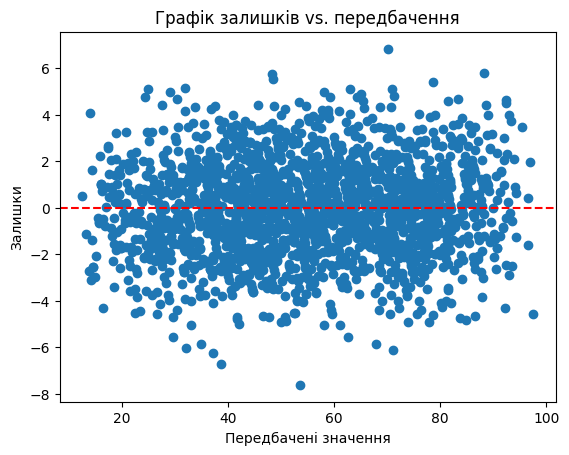

                            feature       VIF
0                     Hours Studied  1.000387
1                   Previous Scores  1.000243
2        Extracurricular Activities  1.000428
3                       Sleep Hours  1.000461
4  Sample Question Papers Practiced  1.000320


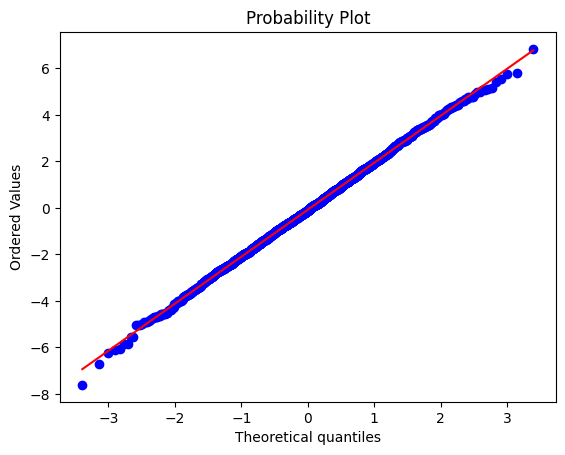

Shapiro-Wilk test p-value: 0.9751496629506848
Durbin-Watson: 2.047191047494784


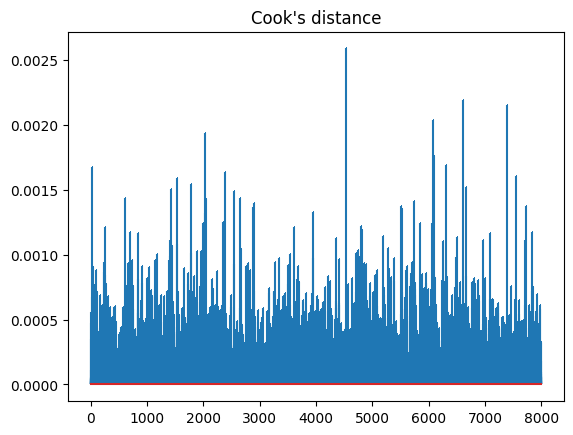

In [11]:
# Залишки
residuals = y_test - y_pred

# Лінійність і гомоскедастичність
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Передбачені значення')
plt.ylabel('Залишки')
plt.title('Графік залишків vs. передбачення')
plt.show()

# Мультиколінеарність
X_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
vif_data = pd.DataFrame()
vif_data['feature'] = X_scaled_df.columns
vif_data['VIF'] = [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]
print(vif_data)

# Нормальність залишків
stats.probplot(residuals, plot=plt)
plt.show()
shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk test p-value:", shapiro_test.pvalue)

# Тест Дарбіна-Вотсона (відсутність автокореляції)
dw = sm.stats.stattools.durbin_watson(residuals)
print("Durbin-Watson:", dw)

# Виявлення викидів (Cook's distance)
X_train_sm = sm.add_constant(X_train_scaled)
model = sm.OLS(y_train, X_train_sm).fit()
influence = model.get_influence()
cooks = influence.cooks_distance[0]
plt.stem(cooks, markerfmt=",")
plt.title("Cook's distance")
plt.show()


In [12]:
print("Коефіцієнти b_final:", b_final)

Коефіцієнти b_final: [55.31149991  7.40134077 17.63727123  0.30429076  0.81003107  0.54884172]
